In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from numpy import quantile, where, random
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

data = pd.read_csv('data/result.csv')
data['outdoor_temp'] = data['outdoor_temp'] +273
data['zone_temp'] = data['zone_temp'] +273
data['supply_temp'] = data['supply_temp'] +273


train = data[91:103]
train = train.reset_index(drop=True)
test = data[103:115]
test = test.reset_index(drop=True)
train.describe()

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
count,12.000000,12.000000,12.00000,12.000000,12.000000
mean,271.454167,294.127447,5.00000,296.218262,0.554818
std,0.703244,0.060387,5.22233,1.985296,0.184877
min,270.900000,294.100013,0.00000,294.180418,0.377812
25%,270.900000,294.100105,0.00000,294.318448,0.377812
50%,271.058333,294.100121,5.00000,296.266778,0.554818
75%,271.929167,294.108215,10.00000,298.119388,0.731824
max,272.800000,294.294280,10.00000,298.134578,0.731824


# Defining Essential Functions

In [187]:
from numpy import random

##Faults:
# 1. Offset Fault: x' = a + x + err
# 2. Gain Fault: x' = Bx+ err
# 3. Stuck at Fault: x' = a
# 4. Out-of-bound: x'<theta1 and x'>theta2

#Function to simulate fault
def simulateFault(sensedValues,params):
    end_fault_index = int(len(sensedValues) * 0.5)
    interval = end_fault_index/4
    BMS = []
    classification = []
    
    noise = random.rand(len(sensedValues)) * params['err']
    for i in range(0, len(sensedValues)):
        if i <= interval:
            a = params['constant']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + a + sensedValues[i])
            else:
                BMS.append(-noise[i] + a + sensedValues[i])
            classification.append(1)

        elif i > interval and i <= interval*2:
            B = params['coeff']
            sign = random.randint(1,3)
            if sign == 1:
                BMS.append(noise[i] + B * sensedValues[i])
            else:
                BMS.append(-noise[i] + B * sensedValues[i])
            classification.append(1)

        elif i > interval*2 and i<= interval*3:
            a = params['stuck']
            BMS.append(a)
            classification.append(1)
            
        elif i > interval*3 and i<= interval*4:
            type_fault = random.randint(1,3)
            low_bound = params['bounds'][0]
            up_bound = params['bounds'][1]
            if type_fault == 1:
                BMS.append(low_bound-noise[i])
            else:
                BMS.append(up_bound + noise[i])
            classification.append(1)
        else:
            BMS.append(noise[i] + sensedValues[i])
            classification.append(0)

    BMS = np.array(BMS)
    BMS = BMS.round(decimals = 3)
    sensedValues = sensedValues.round(decimals=3)
    return np.array(BMS), np.array(classification)

#Function to generate noise
def generateNoise(noise, values):
    noisy_data = []
    for i in range(0,len(values)):
        noisy_data.append(values[i]+random.uniform(-noise,noise))
    return noisy_data

#Function to model equation given the coeffs
def modeled_equation(vals,coeffs):
    x1 = []
    x2 = []
    x = []
    y = []
    for i in range(1,len(vals)):
        c = (1231*240*(vals['zone_temp'][i]-vals['zone_temp'][i-1])/300)
        c = c - (0.57*(vals['supply_temp'][i] - vals['zone_temp'][i])*1.005*vals['air_flow'][i])
        c = c - 100 * vals['occupancy'][i]
        y.append(c)
        x1.append(100)
        x2.append(vals['outdoor_temp'][i]-vals['zone_temp'][i])
    inputs = {'x1':x1, 'x2':x2}
    output = {'y':y}
    return inputs, output

#Function to define vectors for regression model
def define_vectors(vals):
    x1 = []
    x2 = []
    x = []
    y = []
    for i in range(1,len(vals)):
        c = (1231*240*(vals['zone_temp'][i]-vals['zone_temp'][i-1])/300)
        c = c - (0.57*(vals['supply_temp'][i] - vals['zone_temp'][i])*1.005*vals['air_flow'][i])
        c = c - 100 * vals['occupancy'][i]
        y.append(c)
        x1.append(100)
        x2.append((vals['outdoor_temp'][i]-vals['zone_temp'][i]))
    inputs = {'x1':x1, 'x2':x2}
    output = {'y':y}
    return inputs, output

In [188]:
inputs, output = define_vectors(train)
#print(inputs['x'][1])
# print(inputs['x1'][1])
# print(inputs['x2'][1])
# print(inputs['x3'][1])
# print(output['y'][1])
inputs_test, output_test = define_vectors(test)
print(inputs)
print(output)

{'x1': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], 'x2': [-23.200124750000043, -23.20012251000003, -23.200120080000033, -23.20011751000004, -23.20011482000001, -22.883406882999964, -22.566709167, -22.250012889999994, -21.965813362999995, -21.718417896999995, -21.49427996999998]}
{'y': [-0.869025638101852, -0.8716509001153234, -0.8736143880230134, -0.8749941062222272, -0.8758272625165431, -1000.183907641092, -1000.1108935758293, -1000.0628678829403, -968.0688819882948, -931.8343929756986, -908.9376771885003]}


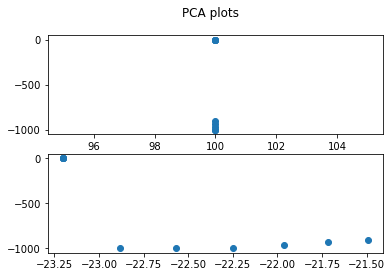

In [189]:
fig, axs = plt.subplots(2)
fig.suptitle('PCA plots')
axs[0].scatter(inputs['x1'], output['y'])
axs[1].scatter(inputs['x2'], output['y'])
plt.show()

# Scaling data 

In [190]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler1 = StandardScaler()
scaler2 = StandardScaler()

inputs = pd.DataFrame(data = inputs)
#inputs = sm.add_constant(inputs) #We add constant because statsmodel library requires us. Otherwise, it would take the form: y = mx.
output = pd.DataFrame(data = output)

inputs_test = pd.DataFrame(data = inputs_test)
#inputs_test = sm.add_constant(inputs_test)
output_test = pd.DataFrame(data = output_test)

inputs_scaled = scaler1.fit_transform(inputs)
output_scaled = scaler2.fit_transform(output)

inputs_scaled_test = scaler1.transform(inputs_test)
output_scaled_test = scaler2.transform(output_test)

# Fitting training data to OLS regression

In [191]:
#x1: M_n
#x2: Q_n
#x3: R_n
model = sm.OLS(output_scaled, inputs)
results = model.fit()
results.params
results.summary()

/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     16.02
Date:                Sun, 23 May 2021   Prob (F-statistic):            0.00310
Time:                        10:49:07   Log-Likelihood:                -9.9854
No. Observations:                  11   AIC:                             23.97
Df Residuals:                       9   BIC:                             24.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2863      0.072     -4.001      0.003      -0.448      -0.124
x2            -1.2652      0.316     -4.002      0.003      -1.980      -0.550
==============================================================================
Omnibus:                        3.787   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                2.134
Skew:                          -1.071   Prob(JB):                        0.344
Kurtosis:                       2.735   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

regr = SVR(C=1.0, epsilon=0.02, kernel = 'rbf')
regr.fit(inputs, output_scaled)
regr.score(inputs,output_scaled)

/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


-0.6184841685338953

# Use Validation Data to check the MSE for the model

In [193]:
from sklearn.metrics import mean_squared_error as mse
pred = results.predict(inputs)
pred_svr = regr.predict(inputs)
err = mse(output_scaled_test,pred)
err_svr = mse(output_scaled_test,pred_svr)

# print(pred_svr)
# print(output_scaled_test)

print(err)
print(err_svr)
print(scaler2.inverse_transform(output_scaled_test))
print(scaler2.inverse_transform(pred_svr))

1.1792781275795732
0.031110691492470456
[[ -894.58091643]
 [ -892.76796961]
 [ -890.977744  ]
 [ -888.96637399]
 [ -887.00574229]
 [ -761.17336131]
 [ -967.47128928]
 [-1062.91392521]
 [-1027.95583418]
 [ -999.01534784]
 [ -991.62492839]]
[-907.92735056 -907.92735189 -907.92735333 -907.92735485 -907.92735644
 -908.11493408 -908.30251696 -908.49009526 -908.65841032 -908.80490772
 -908.93761001]


# Two model comparision: Ground Truth Vs Fault Data

In this case, we take a random day (July 4th) and create two vectors: Ground Truth and Fault data. We assume that the sensor values already incorporate for noise and we just introduce fault for the fault_data vector. We use the build regression model to predict with the learnt coeffs and we use MSE metric to check the difference. 

In [194]:
ground_truth = data[1000:1020]
ground_truth = ground_truth.reset_index(drop=True)
#ground_truth['zone_temp'] = generateNoise(0.5, ground_truth['zone_temp'])

fault_data = data[1000:1020]
fault_data = fault_data.reset_index(drop=True)
stuck_val = random.randint(16,32)
# fault_data['zone_temp'],classification = simulateFault(fault_data['zone_temp'],{'constant': 4.5, 'coeff': 1.4, 'stuck': stuck_val, 'bounds': [16,40],'err':0.5})
fault_data['supply_temp'],classification = simulateFault(fault_data['supply_temp'],{'constant': 100, 'coeff': 1.7, 'stuck': 350, 'bounds': [240,400],'err':0.5})
stuck_val = random.uniform(0,1)
fault_data['air_flow'],classification = simulateFault(fault_data['air_flow'], {'constant': 0.1, 'coeff': 1.005, 'stuck': stuck_val, 'bounds': [0.05,0.8],'err':0.05})
# print(ground_truth)
print(fault_data)

            time  outdoor_temp   zone_temp  occupancy  supply_temp  air_flow
0   1/4/17 11:20    280.066667  295.455591          8      393.488     0.678
1   1/4/17 11:25    280.158333  295.473160          8      393.244     0.697
2   1/4/17 11:30    280.250000  295.490898          8      393.791     0.692
3   1/4/17 11:35    280.341667  295.508343          8      499.383     0.569
4   1/4/17 11:40    280.433333  295.525308          8      499.240     0.635
5   1/4/17 11:45    280.525000  295.542031          8      498.947     0.629
6   1/4/17 11:50    280.616667  295.558664          8      350.000     0.188
7   1/4/17 11:55    280.708333  295.575307          8      350.000     0.188
8   1/4/17 12:00    280.800000  295.591991          8      400.291     0.046
9   1/4/17 12:05    280.841667  295.653042          4      400.491     0.035
10  1/4/17 12:10    280.883333  295.720920          4      239.984     0.033
11  1/4/17 12:15    280.925000  295.758948          4      294.678     0.562

In [195]:
ground_truth_input, ground_truth_output = define_vectors(ground_truth)
fault_input, fault_output = define_vectors(fault_data)

ground_truth_input = pd.DataFrame(data = ground_truth_input)
ground_truth_input = sm.add_constant(ground_truth_input)
ground_truth_output = pd.DataFrame(data = ground_truth_output)

fault_input = pd.DataFrame(data = fault_input)
fault_input = sm.add_constant(fault_input)
fault_output = pd.DataFrame(data = fault_output)

ground_truth_input = scaler1.transform(ground_truth_input)
#ground_truth_output = scaler2.transform(ground_truth_output)
fault_input = scaler1.transform(fault_input)
#fault_output = scaler2.transform(fault_output)

In [196]:
pred_ground = results.predict(ground_truth_input)
#print(ground_truth_input)
print(mse(ground_truth_output,pred_ground))

pred_ground_svr = regr.predict(ground_truth_input)
print(mse(ground_truth_output,pred_ground_svr))

#print(ground_truth_output[0:])
print(pred_ground_svr[0:])

pred_fault = results.predict(fault_input)
pred_fault_svr = regr.predict(fault_input)
#print(pred_fault)
print(pred_fault_svr)
#print(fault_output)
#print(mse(fault_output,pred_fault))
print(mse(fault_output,pred_fault_svr))

324289.96166478796
340078.57551884814
[-0.79670961 -0.79673195 -0.79675428 -0.79677665 -0.79679901 -0.79682129
 -0.79684348 -0.79686556 -0.79685986 -0.79685214 -0.79685322 -0.79686039
 -0.79686988 -0.79687974 -0.79688952 -0.79689935 -0.79690932 -0.79691942
 -0.7969296 ]
[-0.79670961 -0.79673195 -0.79675428 -0.79677665 -0.79679901 -0.79682129
 -0.79684348 -0.79686556 -0.79685986 -0.79685214 -0.79685322 -0.79686039
 -0.79686988 -0.79687974 -0.79688952 -0.79689935 -0.79690932 -0.79691942
 -0.7969296 ]
366768.114601416


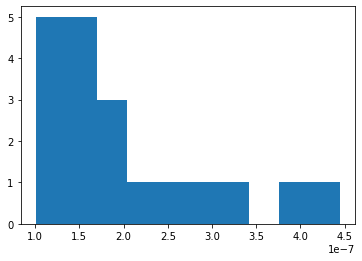

In [197]:
from scipy.stats import boxcox
pred_ground = np.exp(pred_ground)
# power transform
data = boxcox(pred_ground, 0)
plt.hist(pred_ground)
plt.show()

# Experiment: Feedback loop for data collection

In [198]:
#0.703244	0.060387	5.22233	1.985296	0.184877
data = pd.read_csv('data/result.csv')
i = 1002
data2 = data[1000:1002]
data2 = data2.reset_index(drop=True)
stats = data2.describe()
while stats['outdoor_temp']['std'] < 0.7 or stats['zone_temp']['std'] < 0.06 or stats['occupancy']['std'] < 5.22  or stats['supply_temp']['std'] < 1.98 or stats['air_flow']['std'] < 0.18:
    if i > len(data):
        break
    i = i + 1
    data2 = data[1000:i]
    data2 = data2.reset_index(drop=True)
    stats = data2.describe()
# data2['outdoor_temp'] = data2['outdoor_temp'] +273
# data2['zone_temp'] = data2['zone_temp'] +273
# data2['supply_temp'] = data2['supply_temp'] +273
data2.describe()

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
count,104121.000000,104121.000000,104121.000000,104121.000000,104121.000000
mean,16.960498,23.333440,2.880572,22.222592,0.642150
std,8.380649,0.673918,4.191053,2.766931,0.174336
min,-2.700000,21.099926,0.000000,13.642080,0.073377
25%,10.666667,23.102895,0.000000,19.677474,0.661022
50%,16.000000,23.554565,0.000000,23.197447,0.733767
75%,22.833333,23.899437,8.000000,25.000001,0.733767
max,42.000000,24.157065,10.000000,25.446581,0.733767


In [37]:
inputs, output = define_vectors(data2)
data2_test = data[i:i+12]
data2_test = data2_test.reset_index(drop=True)
inputs_test, output_test = define_vectors(data2_test)

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [38]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

inputs = pd.DataFrame(data = inputs)
inputs = sm.add_constant(inputs) #We add constant because statsmodel library requires us. Otherwise, it would take the form: y = mx.
output = pd.DataFrame(data = output)

inputs_test = pd.DataFrame(data = inputs_test)
inputs_test = sm.add_constant(inputs_test,has_constant='add')
output_test = pd.DataFrame(data = output_test)

inputs_scaled = scaler1.fit_transform(inputs)
output_scaled = scaler2.fit_transform(output)

inputs_scaled_test = scaler1.transform(inputs_test)
output_scaled_test = scaler2.transform(output)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by StandardScaler.

In [39]:
model = sm.OLS(output_scaled, inputs_scaled)
results = model.fit()
print(results.summary())
print(results.params)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                              83.62
Date:                Sat, 22 May 2021   Prob (F-statistic):                    3.59e-06
Time:                        22:24:44   Log-Likelihood:                         -3.3066
No. Observations:                  11   AIC:                                      8.613
Df Residuals:                      10   BIC:                                      9.011
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [40]:
pred = results.predict(inputs_scaled_test)
err = mse(output_scaled_test,pred)
print(err)

28.44760077864297
